# Problem: Predicting the closing prices of Tesla stock
## Steps needed to be taken for the training model

### Step 1: Defining the problem
- I want to create a LSTM model which predict the closing prices of Tesla stock from July 2015 -> Today 

### Step 2: Measure of success
- The prediction is 70%+ accurate

In [2]:
# Imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
# The LSTM Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
# Used to normalize data
from sklearn.preprocessing import MinMaxScaler
# Used to measure performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Breaking the data down into train and testing 
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Stock information
import yfinance as yf

### Step 3: Dataset assembly

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

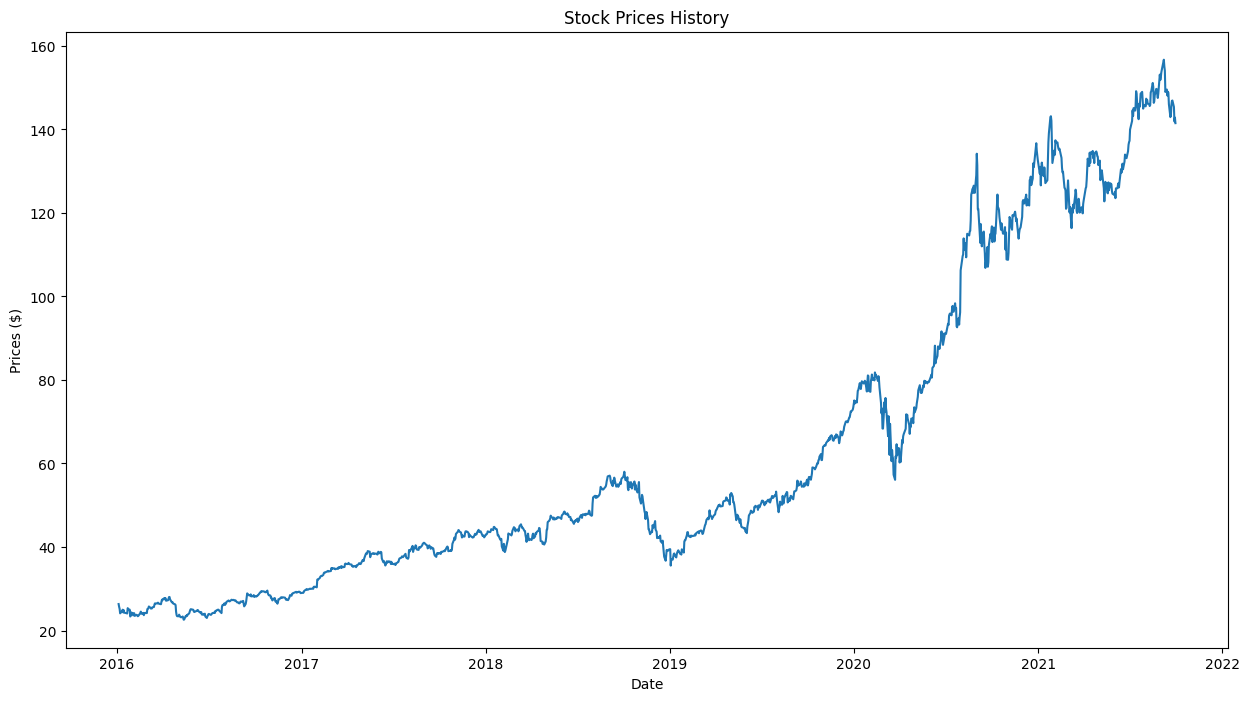

In [3]:
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.head()


plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

### Step 4: Data preparation
- The EDA in this step will be ultimately skipped since the data given was already cleaned
  - The insight which would possibly be gained from searching is negligible 

In [4]:
stock_data.shape

(1447, 6)

## Data Processing
- The goal here is to separate our data into:
  - TRAINING DATA = what our model will use to predict the stock prices
  - TEST DATA = unseen data that our will go up against our model

In [5]:
# Making test vs training data

# taking the closing prices of our chosen stock and transforming it into a number series
close_prices = stock_data['Close']
close_price_values = close_prices.values
# math.ceil ensure the values come out as a rounded integer; this is to figure out get 80% of our dataset
training_data_len = math.ceil(len(close_price_values)* 0.8) 

# usine MinMaxScaler to normalize all of our close prices to a range of 0->1
scaler = MinMaxScaler(feature_range=(0,1)) 
# chaning our scaled data into a two dimensional array
scaled_data = scaler.fit_transform(close_price_values.reshape(-1,1))
# this uses the length of the training data to get 80% of the training data for future training
train_data = scaled_data[0: training_data_len, :]

# our feature data (columns)
x_train = []
# our label data
y_train = []

for i in range(60, len(train_data)):
    # Create a 60-days window of historical prices (i-60) as our feature data (x_train) and the following 60-days window as label data (y_train).
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
# converting both lists into numpy arrays since this is what is accepted by Tensor flow when training a NN
x_train, y_train = np.array(x_train), np.array(y_train)
# reshaping the data to be 3d in order to train a LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Test Data Preparation

In [6]:
# getting the last 20% of our dataset
test_data = scaled_data[training_data_len-60: , : ]
# same process as before
x_test = []
y_test = close_price_values[training_data_len:]


for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# conversion to an array to Tensorflow
x_test = np.array(x_test)
# reshaped to be three dimensional
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Making our LSTM Architecture

In [7]:
# Making our LSTM
# Define a Sequential model which consists of a linear stack of layers.
model = tf.keras.Sequential()
# Add a LSTM layer by giving it 100 network units. Set the return_sequence to true so that the output of the layer will be another sequence of the same length.
model.add(tf.keras.layers.LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1],1)))
# how much of the layers will be dropped ie 20%
model.add(tf.keras.layers.Dropout(0.2))
# 2nd layer of LSTM
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# 3rd LSTM layer
# Add another LSTM layer with also 100 network units. But we set the return_sequence to false for this time to only return the last output in the output sequence.
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
# 4th LSTM layer
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.5))
# dense layer which specifies an output of a single unit
model.add(tf.keras.layers.Dense(units=25))
model.add(tf.keras.layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

# Compiling Our Model

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
35/35 [==============================] - 15s 95ms/step - loss: 0.0070
Epoch 2/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0023
Epoch 3/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0015
Epoch 4/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0012
Epoch 5/100
35/35 [==============================] - 3s 92ms/step - loss: 0.0014
Epoch 6/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0012
Epoch 7/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0011
Epoch 8/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0010
Epoch 9/100
35/35 [==============================] - 3s 91ms/step - loss: 0.0010
Epoch 10/100
35/35 [==============================] - 3s 94ms/step - loss: 0.0011
Epoch 11/100
35/35 [==============================] - 3s 93ms/step - loss: 0.0011
Epoch 12/100
35/35 [==============================] - 4s 108ms/step - loss: 0.0012
Epoch 13/100
35/35 [===

# Model Evaluation

In [9]:
# Model eval
# apply the model on the test data 
predictions = model.predict(x_test)
# denormalize the transformed ataset
predictions = scaler.inverse_transform(predictions)
# applies the degree of idscrepancy between the predicted stock prices and the real prices of y_test
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 2s 37ms/step


4.910895958078774

C:\Users\fuse1\AppData\Local\Temp\ipykernel_14084\4037017934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


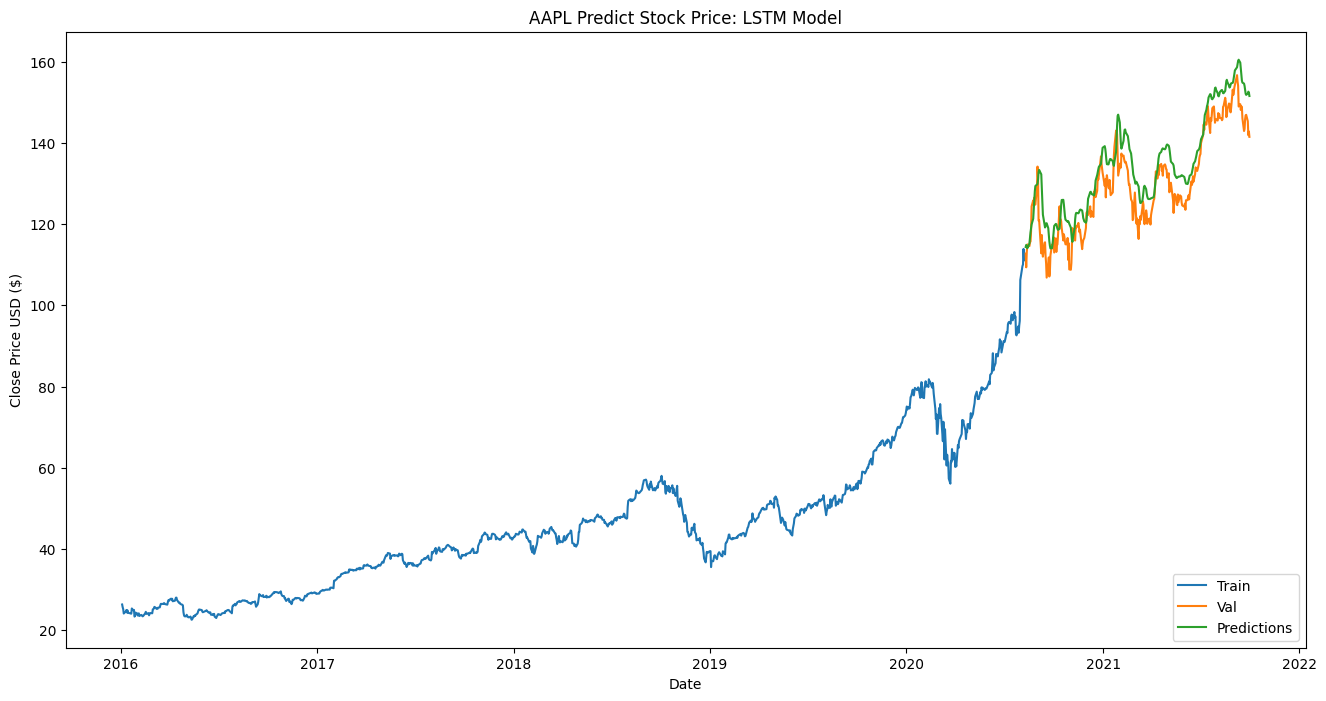

In [10]:
# Visual Builing
data = stock_data.filter(['Close'])

# training data
train = data[: training_data_len]
# validation
validation = data[training_data_len:]
# prediction data
validation['Predictions'] = predictions
# Plotting a figure of size 16 x 8
plt.figure(figsize=(16,8))
plt.title('AAPL Predict Stock Price: LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# plot the training data
plt.plot(train)
# plotting the close data against our predictions
plt.plot(validation[['Close', 'Predictions']])
# legend
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()